In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.sql.functions import col, avg, udf, when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


In [25]:
spark = SparkSession.builder \
    .appName("categorie immat") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [26]:
spark.sql("USE concessionnaire")
immatriculation_df = spark.sql("SELECT * FROM client_immatriculation_merged")

In [27]:
immatriculation_df.show(20)

+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+
|immatriculation|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture| marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|   prix|modele|
+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+
|        0 OG 13| 56|Homme| 528|        Célibataire|              0|          false|   Audi|       75|     courte|       5|       5|  blanc|    true|12817.0|    A2|
|        0 OZ 65| 32|Homme| 563|          En Couple|              2|          false|   Ford|      125|     longue|       5|       5|  blanc|   false|23900.0|Mondeo|
|        1 PD 24| 28|Homme| 230|          En Couple|              2|          false|Renault|      245|très longue|       5|       5|  blanc|    true|34440.0|   Vel|
|       10

In [28]:
length_mapping = {
    "courte": 1.0,
    "moyenne": 2.0,
    "longue": 3.0,
    "très longue": 4.0
}

situation_mapping = {
    "Célibataire": 0.0,
    "En Couple": 1.0
}


map_length = udf(lambda x: length_mapping.get(x, 0.0), DoubleType())
map_situation = udf(lambda x: situation_mapping.get(x, 0.0), DoubleType())

immatriculation_df = immatriculation_df.withColumn("longueur", map_length(col("longueur")))
immatriculation_df = immatriculation_df.withColumn("situationfamilliale", map_situation(col("situationfamilliale")))


In [29]:
immatriculation_df = immatriculation_df.withColumn("puissance", col("puissance").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("nbPortes", col("nbPortes").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("prix", col("prix").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("age", col("age").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("sexe",when(col("sexe") == "Homme", 1).when(col("sexe") == "Femme", 0).otherwise(None))
immatriculation_df = immatriculation_df.withColumn("nbenfantacharge", col("nbenfantacharge").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("deuxiemevoiture",when(col("deuxiemevoiture") == "true", 1).when(col("deuxiemevoiture") == "false", 0).otherwise(None))

In [30]:
immatriculation_df.show(10)


+---------------+----+----+----+-------------------+---------------+---------------+-------+---------+--------+--------+--------+-------+--------+-------+------+
|immatriculation| age|sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture| marque|puissance|longueur|nbplaces|nbPortes|couleur|occasion|   prix|modele|
+---------------+----+----+----+-------------------+---------------+---------------+-------+---------+--------+--------+--------+-------+--------+-------+------+
|        0 OG 13|56.0|   1| 528|                0.0|            0.0|              0|   Audi|     75.0|     1.0|       5|     5.0|  blanc|    true|12817.0|    A2|
|        0 OZ 65|32.0|   1| 563|                1.0|            2.0|              0|   Ford|    125.0|     3.0|       5|     5.0|  blanc|   false|23900.0|Mondeo|
|        1 PD 24|28.0|   1| 230|                1.0|            2.0|              0|Renault|    245.0|     4.0|       5|     5.0|  blanc|    true|34440.0|   Vel|
|       10 EW 37|33.0|   0| 

In [31]:
features_df = immatriculation_df.select("puissance", "longueur", "nbPortes", "prix", "age", "sexe", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture")

In [32]:
assembler = VectorAssembler(inputCols=["puissance", "longueur", "nbPortes", "prix", "age", "sexe", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture"], outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(features_df)

In [33]:
features_df.select("puissance", "longueur", "nbPortes", "prix", "age", "sexe", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture").show(10)


+---------+--------+--------+-------+----+----+---------------+-------------------+---------------+
|puissance|longueur|nbPortes|   prix| age|sexe|nbenfantacharge|situationfamilliale|deuxiemevoiture|
+---------+--------+--------+-------+----+----+---------------+-------------------+---------------+
|     75.0|     1.0|     5.0|12817.0|56.0|   1|            0.0|                0.0|              0|
|    125.0|     3.0|     5.0|23900.0|32.0|   1|            2.0|                1.0|              0|
|    245.0|     4.0|     5.0|34440.0|28.0|   1|            2.0|                1.0|              0|
|    197.0|     3.0|     5.0|37100.0|33.0|   0|            1.0|                1.0|              0|
|    197.0|     3.0|     5.0|37100.0|20.0|   1|            2.0|                1.0|              0|
|    272.0|     4.0|     5.0|50500.0|21.0|   1|            2.0|                1.0|              0|
|     75.0|     1.0|     5.0|18310.0|22.0|   1|            0.0|                0.0|              0|


In [34]:
# Standardiser les caractéristiques pour les ramener à la même échelle
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

In [36]:
k = 5
kmeans = KMeans(featuresCol="scaled_features", predictionCol="category", k=k)
model = kmeans.fit(scaled_df)

In [37]:
clustered_df = model.transform(scaled_df)

In [38]:
result_df = clustered_df.select("age", "longueur", "prix", "sexe", "category", "features")
result_df.show(10)

+----+--------+-------+----+--------+--------------------+
| age|longueur|   prix|sexe|category|            features|
+----+--------+-------+----+--------+--------------------+
|56.0|     1.0|12817.0|   1|       1|[75.0,1.0,5.0,128...|
|32.0|     3.0|23900.0|   1|       2|[125.0,3.0,5.0,23...|
|28.0|     4.0|34440.0|   1|       2|[245.0,4.0,5.0,34...|
|33.0|     3.0|37100.0|   0|       2|[197.0,3.0,5.0,37...|
|20.0|     3.0|37100.0|   1|       2|[197.0,3.0,5.0,37...|
|21.0|     4.0|50500.0|   1|       2|[272.0,4.0,5.0,50...|
|22.0|     1.0|18310.0|   1|       1|[75.0,1.0,5.0,183...|
|29.0|     1.0|18200.0|   0|       1|[115.0,1.0,5.0,18...|
|41.0|     3.0|23900.0|   1|       2|[125.0,3.0,5.0,23...|
|50.0|     4.0|94800.0|   1|       0|[507.0,4.0,5.0,94...|
+----+--------+-------+----+--------+--------------------+
only showing top 10 rows



In [40]:
final_df = clustered_df.select(
    "puissance", 
    "longueur", 
    "nbPortes", 
    "prix", 
    "age",
    "sexe",
    "nbenfantacharge", 
    "situationfamilliale", 
    "deuxiemevoiture", 
    "category"
)

# Save
final_df.write.mode("overwrite").saveAsTable("client_immat_cat")

# Analyse des clusters

In [41]:
from pyspark.sql import functions as F

cluster_summary = clustered_df.groupBy("category").agg(
    F.avg("puissance").alias("moy_puissance"),
    F.avg("longueur").alias("moy_longueur"),
    F.avg("nbPortes").alias("moy_nbPortes"),
    F.avg("prix").alias("moy_prix"),
    F.avg("age").alias("moy_age"),
    F.avg("nbenfantacharge").alias("moy_nbenfantacharge")
)
cluster_summary.show()


+--------+-----------------+------------------+-----------------+------------------+------------------+-------------------+
|category|    moy_puissance|      moy_longueur|     moy_nbPortes|          moy_prix|           moy_age|moy_nbenfantacharge|
+--------+-----------------+------------------+-----------------+------------------+------------------+-------------------+
|       1|100.3968233919606|1.4809750860462914| 4.73993495216142|17527.853989706022| 43.74075594429884|0.07458397802267201|
|       3|355.4738906594754|               4.0|              5.0|65411.696494238786|43.609463103701884| 3.5062515322382937|
|       4| 71.4254647887324|               1.0|4.453521126760563|13821.114591549296|44.222084507042254| 0.9962816901408451|
|       2|191.6927724964188| 3.353040760515692|              5.0|  33181.8953249121|42.308555801536656| 1.5786170074228416|
|       0| 449.912746585736|               4.0|              5.0| 84073.51416287303| 46.83238492665655|  2.401555386949924|
+-------

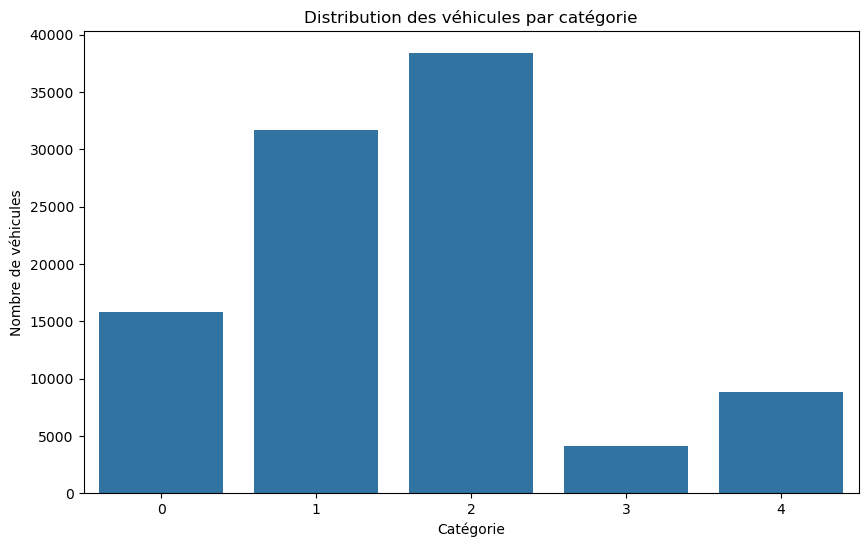

In [42]:
category_counts = result_df.groupBy("category").count().orderBy("category").collect()
categories = [row["category"] for row in category_counts]
counts = [row["count"] for row in category_counts]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de véhicules")
plt.title("Distribution des véhicules par catégorie")
plt.show()

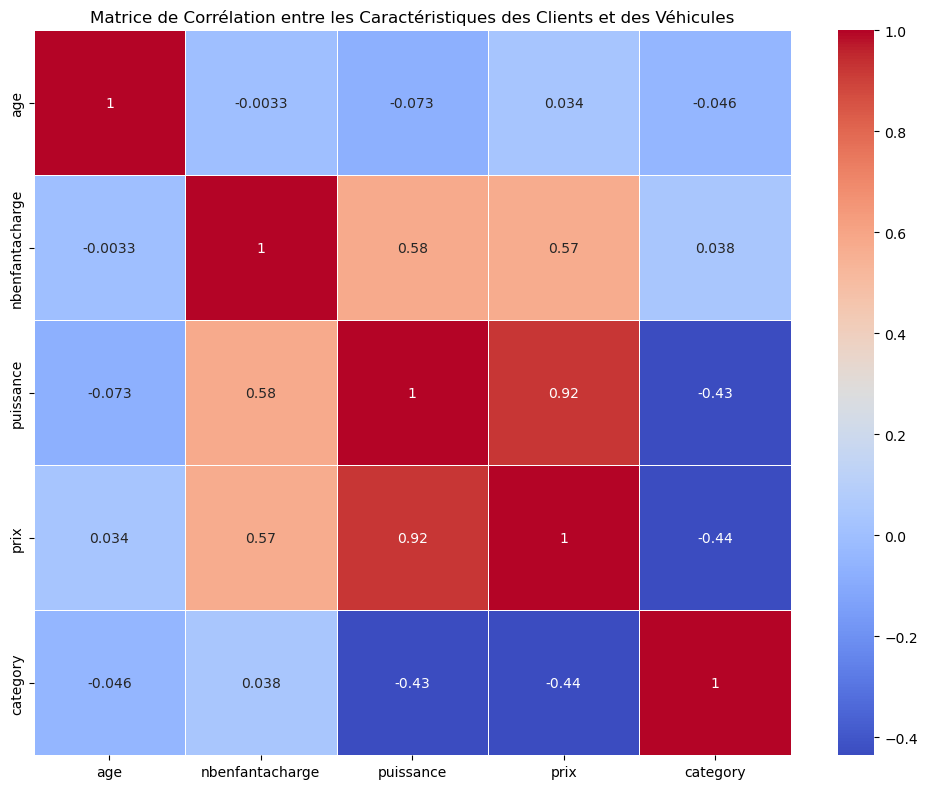

In [43]:
numerical_columns = ["age", "nbenfantacharge", "puissance", "prix", "category"]
numerical_df = clustered_df.select(numerical_columns)

numerical_df_pandas = numerical_df.toPandas()

# Calculer la matrice de corrélation
corr_matrix = numerical_df_pandas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation entre les Caractéristiques des Clients et des Véhicules")
plt.tight_layout()
plt.show()